In [1]:
from deep_rl import *
from my_agent import MyLLAgent

from my_logger import *
from my_config import *

import matplotlib
import matplotlib.pyplot as plt

import os

In [35]:
set_one_thread()
select_device(-1) # -1 is CPU, a positive integer is the index of GPU

# path = "log/minigrid_score_decay-42-mask-linear_comb/231026-110040"             # sparse
path = "log_safe/minigrid_green_blue-42-mask-linear_comb/230706-121833"          # normal
config, agent = build_minigrid_config(None, log_dir=path)

# load agent
model_path = '{0}/{1}-{2}-model-{3}.bin'.format(path, config.agent_name, config.tag, config.env_name)
agent.load(model_path)

In [36]:
obs_vec = np.load("log/minigrid_score_decay-42-mask-linear_comb/231030-112814/obs.npy")
(obs_vec > 0).sum()

obs_vec = np.insert(obs_vec, -1, 0)
obs_vec

array([ 8024.,   810.,  1873.,     0.,     0.,     0.,   103.,   107.,
           0.,     0.,     0.,  8834.,   113.,    97.,     0.,     0.,
        1873., 10917.,     0.,     0.,  6162.,  1800.,  2516.,     0.,
           0.,     0.,   204.,   235.,     0.,     0.,     0.,  7962.,
         189.,   250.,     0.,     0.,  2516., 10917.,     0.,     0.,
        4473.,  2896.,  2837.,     0.,     0.,     0.,   365.,   346.,
           0.,     0.,     0.,  7369.,   367.,   344.,     0.,     0.,
        2837., 10917.,     0.,     0.,  2419.,  3954.,  3626.,     0.,
           0.,     0.,   464.,   454.,     0.,     0.,     0.,  6373.,
         468.,   450.,     0.,     0.,  3626., 10917.,     0.,     0.,
        2419.,  5402.,  2077.,     0.,     0.,     0.,   508.,   511.,
           0.,     0.,     0.,  7821.,   532.,   487.,     0.,     0.,
        2077., 10917.,     0.,     0.,  7154.,  1072.,  2454.,     0.,
           0.,     0.,   131.,   106.,     0.,     0.,     0.,  8226.,
      

In [31]:
len(obs_vec)

505

In [37]:
for k, v in agent.network.named_parameters():
    k_split = k.split('.')

    # remove every module that is not a mask (e.g., .weight, .betas)
    try: k_split[-1] = int(k_split[-1])
    except: continue

    n_active = (v >= 0).sum()
    n_cons = v.shape[0] * v.shape[1]
    active = n_active / n_cons
    print(k, active)

network.phi_body.layers.0.scores.0 tensor(0.5003)
network.phi_body.layers.0.scores.1 tensor(0.4970)
network.phi_body.layers.0.scores.2 tensor(0.4980)
network.phi_body.layers.0.scores.3 tensor(0.4947)
network.phi_body.layers.1.scores.0 tensor(0.5048)
network.phi_body.layers.1.scores.1 tensor(0.5084)
network.phi_body.layers.1.scores.2 tensor(0.5031)
network.phi_body.layers.1.scores.3 tensor(0.5090)
network.phi_body.layers.2.scores.0 tensor(0.5037)
network.phi_body.layers.2.scores.1 tensor(0.5023)
network.phi_body.layers.2.scores.2 tensor(0.5054)
network.phi_body.layers.2.scores.3 tensor(0.5062)
network.fc_action.scores.0 tensor(0.5450)
network.fc_action.scores.1 tensor(0.5725)
network.fc_action.scores.2 tensor(0.5625)
network.fc_action.scores.3 tensor(0.5825)
network.fc_critic.scores.0 tensor(0.3500)
network.fc_critic.scores.1 tensor(0.4350)
network.fc_critic.scores.2 tensor(0.4050)
network.fc_critic.scores.3 tensor(0.4900)


In [38]:
weight_matrix = None

for k, v in agent.network.named_parameters():
    # only score values
    if 'scores' not in k:
        continue
    # only the current index
    if int(k.split('.')[-1]) != 0:
        continue

    print(k, v.shape)

    if k == 'network.phi_body.layers.0.scores.0':
        weight_matrix = v.data

network.phi_body.layers.0.scores.0 torch.Size([200, 508])
network.phi_body.layers.1.scores.0 torch.Size([200, 200])
network.phi_body.layers.2.scores.0 torch.Size([200, 200])
network.fc_action.scores.0 torch.Size([4, 200])
network.fc_critic.scores.0 torch.Size([1, 200])


0.5002475247524752


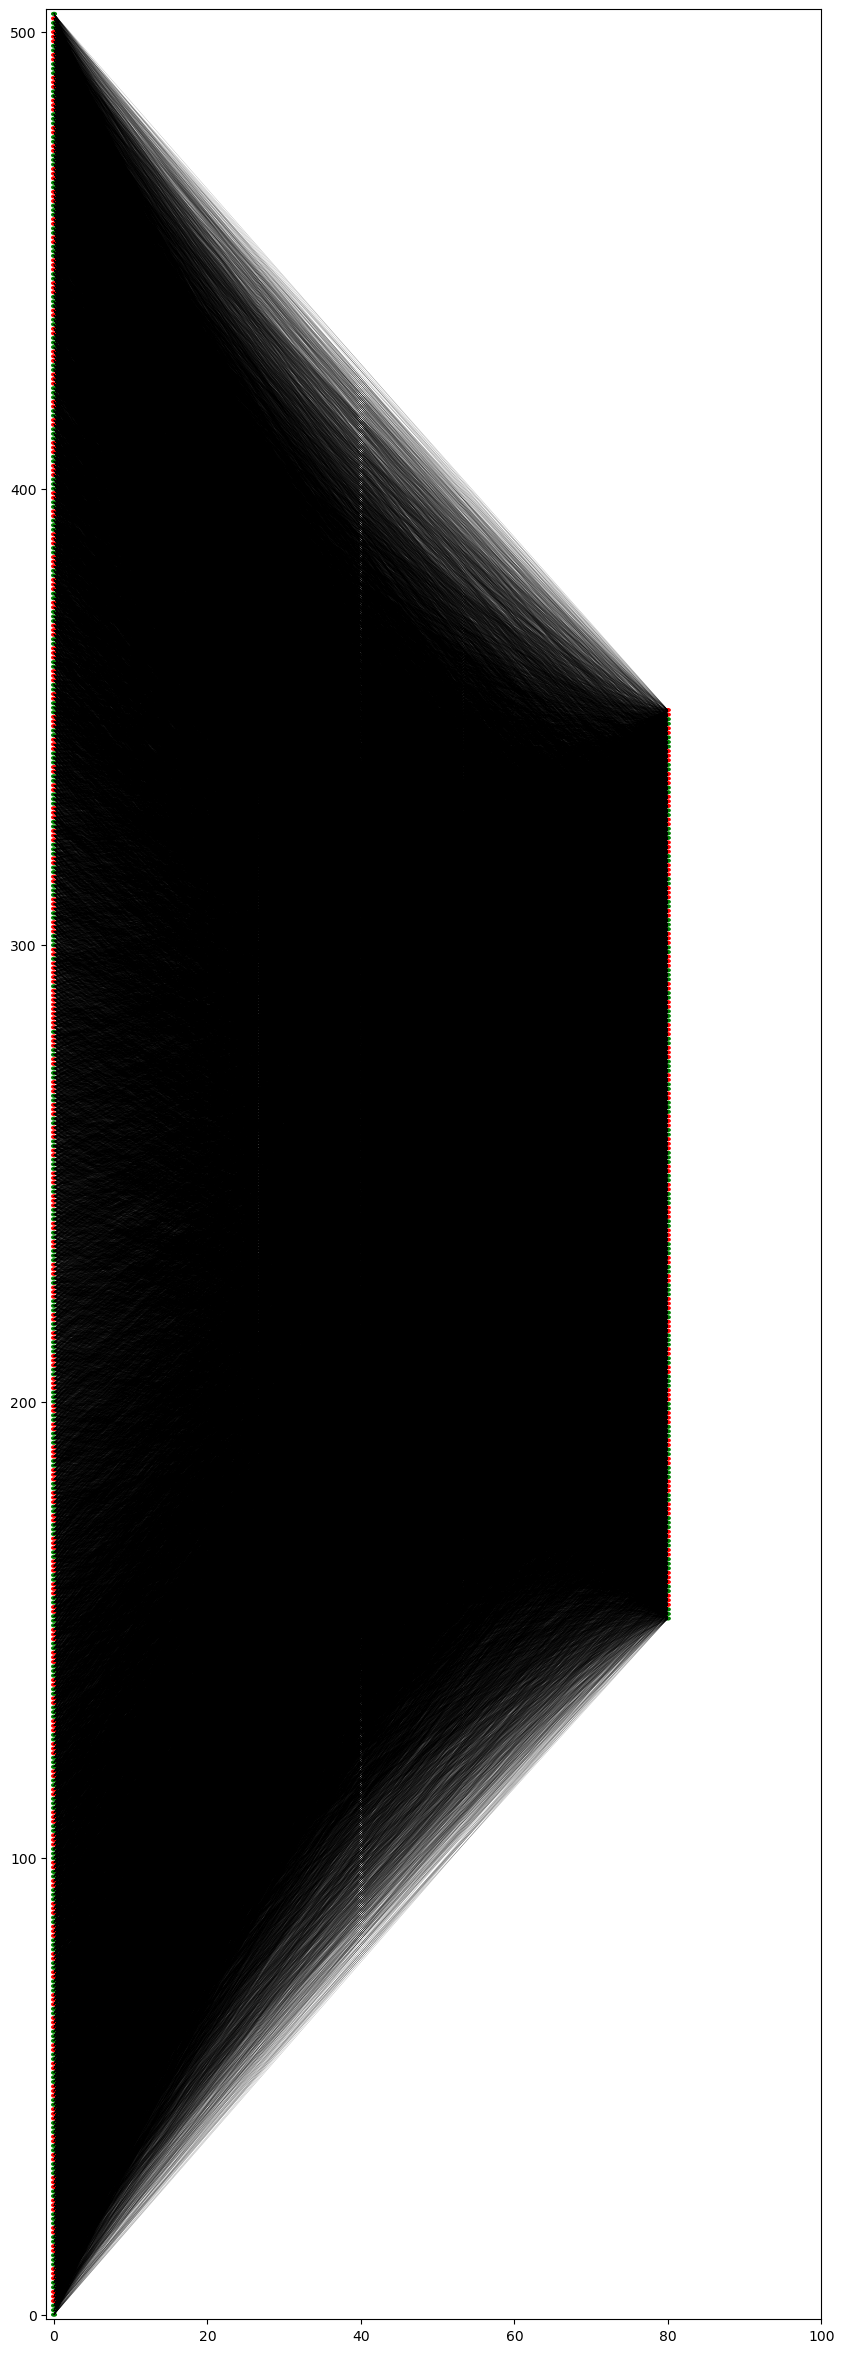

In [39]:
matplotlib.use('module://ipykernel.pylab.backend_inline')

fig, ax = plt.subplots(figsize=(10, 30))

dimensions = [505, 200]

positions = []
for i, n in enumerate(dimensions):
    positions.append(np.arange(max(dimensions) / 2 - n / 2, max(dimensions) / 2 + n / 2))

yes = 0
summ = 0
for i in range(dimensions[0]):
    for k in range(dimensions[1]):
        if weight_matrix[k, i] >= 0:
            line = plt.Line2D([0, 80], [positions[0][i], positions[1][k]], color='black', lw=0.1, alpha=0.8)
            ax.add_line(line)
            yes += 1
        summ += 1

for i, pos in enumerate(positions):
    for k, p in enumerate(pos):
        circle = plt.Circle((i * 80, p), 0.3, color="green" if obs_vec[k] > 0 else "red", alpha=1)
        ax.add_patch(circle)

print(yes / summ)

ax.set_xlim(-1, 100)
ax.set_ylim(-1, max(dimensions))
plt.show()

## Analyse how Masks change during Training

In [51]:
def _plot_hm_layer_mask_diff(data, title, fname, vmin=None):
    n_tasks = data.shape[0]

    fig = plt.figure(figsize=(9, 9))
    ax = fig.subplots()
    im = ax.imshow(data, cmap='BuPu', vmin=vmin)
    ax.set_xticks(np.arange(n_tasks), labels=['T{0}'.format(idx + 1) for idx in range(n_tasks)], \
        fontsize=20)
    ax.set_yticks(np.arange(n_tasks), labels=['T{0}'.format(idx + 1) for idx in range(n_tasks)], \
        fontsize=20)

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    for i in range(n_tasks):
        for j in range(n_tasks):
         text = ax.text(j, i, '{0:.2f}'.format(data[i, j]), ha='center', \
            va='center', fontsize=12)
    ax.set_title(title, fontsize=24)
    fig.savefig(fname)
    plt.close(fig)

In [56]:
matplotlib.use("Pdf")

path = "log/minigrid_score_decay-42-mask-linear_comb/231031-093915"
if not os.path.exists(f"{path}/inter_training_diff"):
    os.makedirs(f"{path}/inter_training_diff")

layer_names = ['network.phi_body.layers.0.scores.0', 'network.phi_body.layers.1.scores.0', 'network.phi_body.layers.2.scores.0', 'network.fc_action.scores.0', 'network.fc_critic.scores.0']
for layer_name in layer_names:
    names = [f'{layer_name}-{i}.npy' for i in range(20, 340, 20)]
    n_masks = len(names)
    masks = [np.load(f"{path}/{mask_name}") for mask_name in names]
    bin_masks = [mask >= 0 for mask in masks]
    n_weights = bin_masks[0].shape[0] * bin_masks[0].shape[1]

    same_score_sign = np.zeros((n_masks, n_masks))
    for i in range(n_masks):
        for k in range(n_masks):
            same_score_sign[i][k] = (bin_masks[i] == bin_masks[k]).sum() / n_weights

    _plot_hm_layer_mask_diff(same_score_sign, layer_name, f'{path}/inter_training_diff/{layer_name}.pdf')

    # _plot_hm_layer_mask_diff(same_score_sign, \
            # 'Same score sign in percent for {0}'.format(layer_name), \
            # '{0}/mask_diff/{1}'.format(path, layer_name), vmin=0.5)

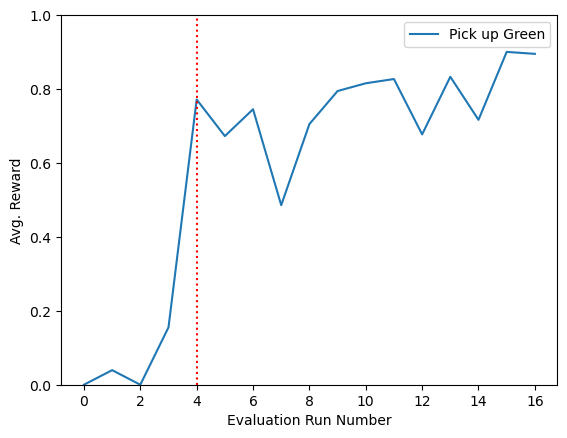

In [15]:
data = np.loadtxt("log/minigrid_score_decay-42-mask-linear_comb/231031-093915/eval_data.csv", delimiter=',')[:,0]
x = np.arange(len(data))
plt.plot(x, data, label='Pick up Green')
plt.xlabel("Evaluation Run Number")
plt.ylabel("Avg. Reward")
plt.ylim(bottom=0, top=1)
plt.axvline(4, c='red', ls=':')
plt.legend()
plt.savefig("log/minigrid_score_decay-42-mask-linear_comb/231031-093915/task_stats/plot.png", bbox_inches='tight')
plt.show()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])